### Notebook to train the behavior generation auxilliary CLASP task 
### IMPORTANT:  The model is broken and does not produce proper results
model and training loop adapted from skillGPT dataset: https://github.com/krishanrana/skillGPT/tree/distributional_SkillGPT

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
from piqa import SSIM
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import os
import csv

from datasets.image_vae_dataset import ImageVAEDataset, ImageVAEDatasetFull
from datasets.bc_dataset import BCDataset
from models.bc.visual_autoencoder import VisualAutoencoder
from models.bc.bc_policy import LanguageConditionedPolicy

import config as CFG

ModuleNotFoundError: No module named 'models.visual_autoencoder'

## VisualAutoencoder

dataloder

In [4]:
caption_path_training = '{}/lang_annotations/auto_lang_ann.npy'.format(CFG.datapath_training)
train_dataset = ImageVAEDataset(dataset_path=CFG.datapath_training, caption_path=caption_path_training)
train_loader = DataLoader(train_dataset,
                          #num_workers=16,
                          #prefetch_factor=6, 
                          batch_size=CFG.batch_size, 
                          shuffle=True)

caption_path_val = '{}/lang_annotations/auto_lang_ann.npy'.format(CFG.datapath_val)
val_dataset = ImageVAEDataset(dataset_path=CFG.datapath_val, caption_path=caption_path_val)
val_loader = DataLoader(val_dataset,
                          #num_workers=16,
                          #prefetch_factor=6, 
                          batch_size=CFG.batch_size, 
                          shuffle=True)


train_dataset_full = ImageVAEDatasetFull(dataset_path=CFG.datapath_training)
train_loader_full = DataLoader(train_dataset_full,
                          #num_workers=16,
                          #prefetch_factor=6, 
                          batch_size=CFG.batch_size, 
                          shuffle=True)

val_dataset_full = ImageVAEDatasetFull(dataset_path=CFG.datapath_val)
val_loader_full = DataLoader(val_dataset_full,
                          #num_workers=16,
                          #prefetch_factor=6, 
                          batch_size=CFG.batch_size, 
                          shuffle=True)

test dataloader

In [ ]:
for idx, batch in enumerate(train_loader):
    print("img_static: ", batch.img_static.shape)
    print("img_gripper: ", batch.img_gripper.shape)
    break


for idx, batch in enumerate(train_dataset):
    print("img_static: ", batch.img_static.shape)
    print("img_gripper: ", batch.img_gripper.shape)
    plt.imshow(np.transpose(batch.img_static, (1, 2, 0)))
    plt.show()
    break

"""
for idx, batch in enumerate(train_loader_full):
    print("img_static: ", batch.img_static.shape)
    print("img_gripper: ", batch.img_gripper.shape)
    break
"""

### Train VAE model

In [ ]:
encoding_size = 512
learning_rate = 0.0001

class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

def visualize_reconstruction(original, reconstructed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original.permute(1, 2, 0))
    axs[0].set_title('Original')
    axs[1].imshow(reconstructed.detach().permute(1, 2, 0))
    axs[1].set_title('Reconstructed')
    plt.close()
    # return figure for wandb
    return fig


def train():
    # Train the model
    step = 0
    checkpoint_step = 0;
    #use tqdm for progress bar
    for epoch in range(CFG.epochs):

        running_loss = 0.0
        print(f"Epoch {epoch+1}/{CFG.epochs}")
        
        #for i, data in enumerate(tqdm(train_loader)):
        for i, data in enumerate(tqdm(train_loader_full)):
            # Get the inputs and move them to the GPU if available
            # inputs = data['img_static']
            inputs = data['img_gripper']
            inputs = inputs.to(CFG.device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            reconstruction_loss = criterion(outputs, inputs)
            #ssim_loss = SSIM_criterion(outputs, inputs) * 0.001

            loss = reconstruction_loss #+ ssim_loss
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Log the loss
            wandb.log({"Total Loss": loss.item()}, step=step)
            wandb.log({"Reconstruction Loss": reconstruction_loss.item()}, step=step)
            #wandb.log({"SSIM Loss": ssim_loss.item()}, step=step)

            #if step % 321 == 0:
            if step % 2000 == 0:
                #visualize_reconstruction(inputs[0].detach().cpu(), outputs[0].detach().cpu())
                wandb.log({"Training Images": wandb.Image(visualize_reconstruction(inputs[0].detach().cpu(), outputs[0].detach().cpu()))}, step=step)
                #save model weights
                torch.save(model.state_dict(), f"checkpoints/image_vae/image_vae_gripper/image_vae_gripper_high_res-{checkpoint_step:03d}.pt")
                checkpoint_step += 1
            
            step += 1
        """
        wandb.log({"Training Images": wandb.Image(visualize_reconstruction(inputs[0].detach().cpu(), outputs[0].detach().cpu()))}, step=step)
        torch.save(model.state_dict(), f"checkpoints/image_vae/image_vae_static_long/image_vae_static_high_res-{epoch:03d}.pt")
        """

wandb.init(project="ImageVAE")
model = VisualAutoencoder(encoding_size)
model.to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
SSIM_criterion = SSIMLoss().cuda()

train()

validate image vae

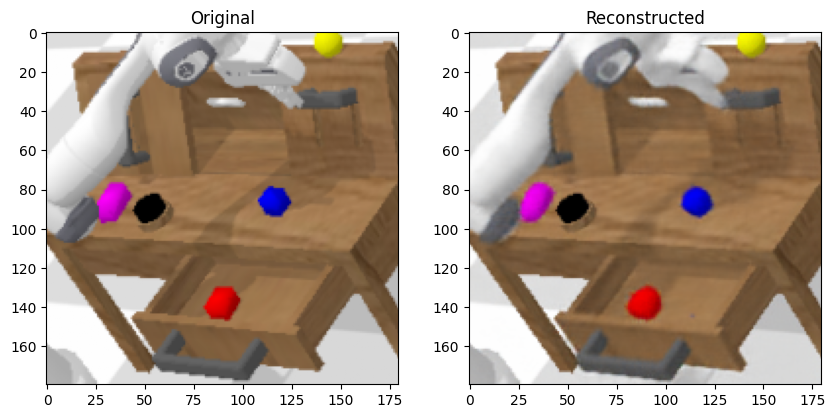

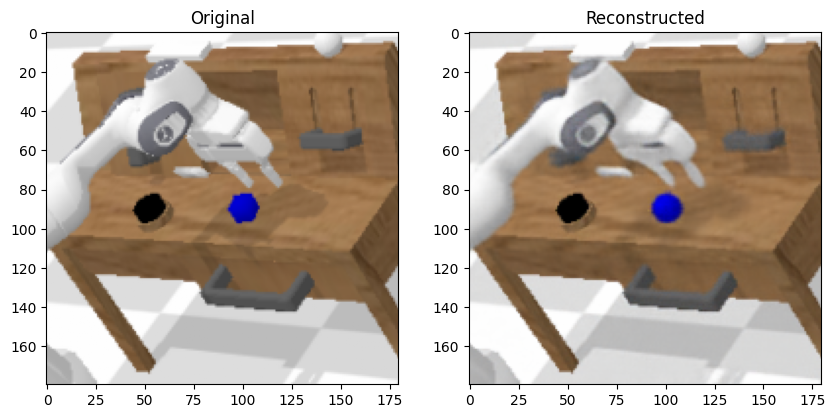

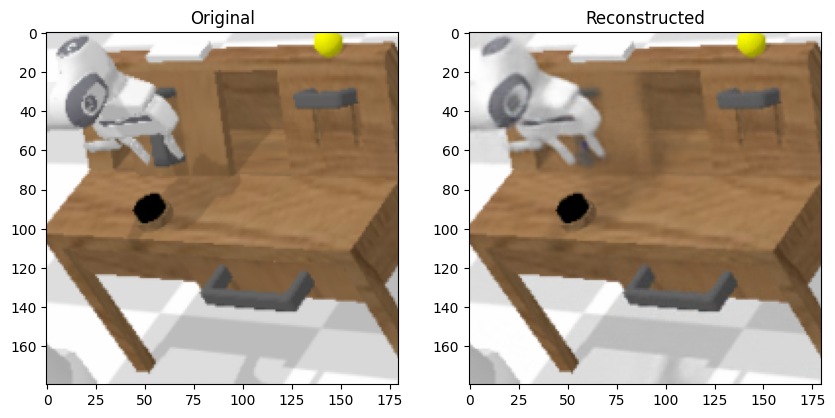

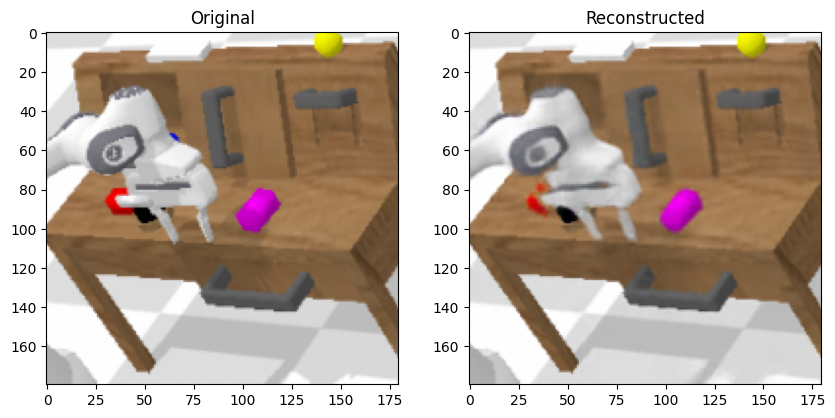

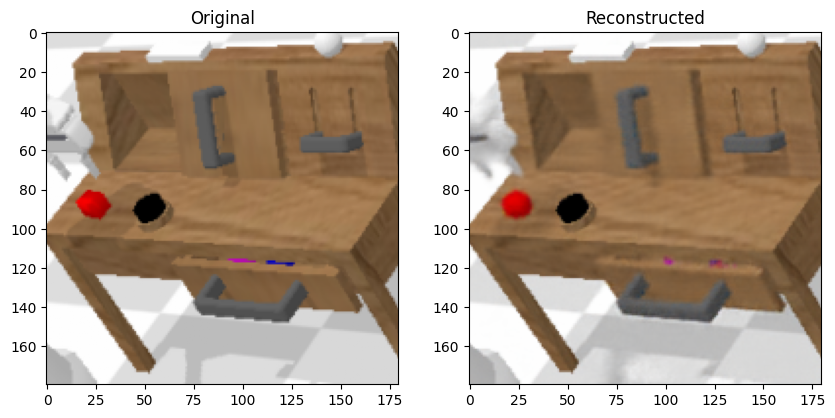

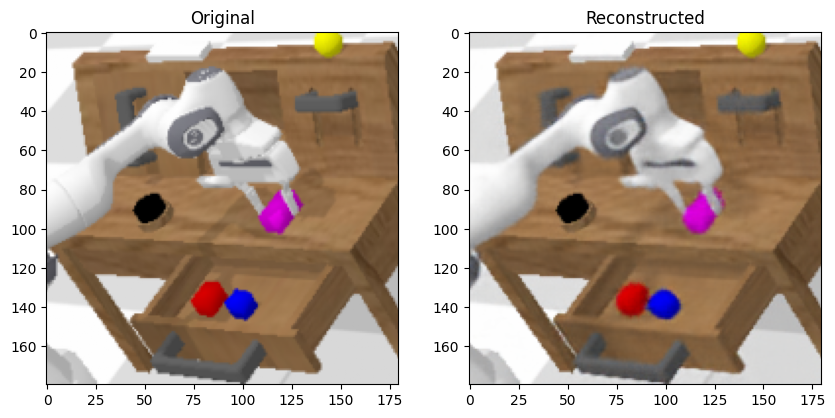

In [5]:
def visualize_reconstruction(original, reconstructed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original.permute(1, 2, 0))
    axs[0].set_title('Original')
    axs[1].imshow(reconstructed.detach().permute(1, 2, 0))
    axs[1].set_title('Reconstructed')
    plt.show()
    plt.close()
    # return figure for wandb
    return fig

def reconstruct(model):
    for i, data in enumerate(val_loader_full):
        inputs = data['img_static']
        inputs = inputs.to(CFG.device)
        outputs = model(inputs)
        for i in range(0, 6):
            visualize_reconstruction(inputs[i].detach().cpu(), outputs[i].detach().cpu())
        break
    
encoding_size = 512
model = VisualAutoencoder(encoding_size).to(CFG.device)
model.load_state_dict(torch.load('checkpoints/image_vae/image_vae_static_full_long/image_vae_static_full_high_res-045.pt', map_location=CFG.device))
model = model.eval()
reconstruct(model)


## Behavior Cloning Policy

dataloader

In [2]:
batch_size = 32

caption_path_training = '{}/lang_annotations/auto_lang_ann.npy'.format(CFG.datapath_training)
train_dataset_bc = BCDataset(data_path=CFG.datapath_training, caption_path=caption_path_training)
train_loader_bc = DataLoader(train_dataset_bc, 
                          batch_size=batch_size, 
                          shuffle=True)

caption_path_val = '{}/lang_annotations/auto_lang_ann.npy'.format(CFG.datapath_val)
val_dataset_bc = BCDataset(data_path=CFG.datapath_val, caption_path=caption_path_val)
val_loader_bc = DataLoader(val_dataset_bc,
                          batch_size=batch_size, 
                          shuffle=True)

test dataloader bc policy

In [3]:
for idx, batch in enumerate(train_loader_bc):
    print("img_static: ", batch.img_static.shape)
    print("img_gripper: ", batch.img_gripper.shape)
    print("robot_obs: ", batch.robot_obs.shape)
    print("robot_obs: ", batch.robot_obs[0])
    print("action: ", batch.action.shape)
    print("rel_action: ", batch.rel_action.shape)
    print("text_encoding: ", batch.text_encoding.shape)

    print("img_static: ", batch.img_static.dtype)
    print("img_gripper: ", batch.img_gripper.dtype)
    print("action: ", batch.action.dtype)
    print("rel_action: ", batch.rel_action.dtype)
    print("robot_obs: ", batch.robot_obs.dtype)
    print("text_encoding: ", batch.text_encoding.dtype)
    break


img_static:  torch.Size([32, 3, 180, 180])
img_gripper:  torch.Size([32, 3, 180, 180])
robot_obs:  torch.Size([32, 15])
robot_obs:  tensor([ 0.1724, -0.3310,  0.5218, -3.1360, -0.1580,  1.3245,  0.0800, -1.2581,
         1.1439,  1.8302, -2.1316, -1.0079,  1.7368,  0.3788,  1.0000])
action:  torch.Size([32, 7])
rel_action:  torch.Size([32, 7])
text_encoding:  torch.Size([32, 512])
img_static:  torch.float32
img_gripper:  torch.float32
action:  torch.float32
rel_action:  torch.float32
robot_obs:  torch.float32
text_encoding:  torch.float16


### Train BC Policy

calc mean and std of robot actions (used in bc_dataset.py)

In [ ]:
# mean and std for entire training data

datafiles = os.listdir(CFG.datapath_training)

all_actions = []
# Loop through and print the file names
for file in tqdm(datafiles):
    try:
        file_path = os.path.join(CFG.datapath_training, file)
        data = np.load(file_path)
        all_actions.append(data["actions"])
    except:
        print(f"Skipping '{file}'")

mean = np.mean(np.array(all_actions), axis=0)
std = np.std(np.array(all_actions), axis=0)

print("mean: ", mean)
print("std: ", std)


In [3]:
wandb.init(project="skillGPT_BC")
device = CFG.device

#hyperparameters
# lr = 0.0001
lr = 0.0001
num_epochs = 1000
language_dim = 512
image_dim = 512
action_dim = 7

def train():
    # loss function
    criterion = nn.MSELoss()

    # Initialize the model
    policy = LanguageConditionedPolicy(language_dim, action_dim)
    policy = policy.to(device)

    # initialize the visual autoencoder
    visual_autoencoder_static = VisualAutoencoder(512)
    visual_autoencoder_static = visual_autoencoder_static.to(device)
    visual_autoencoder_static.load_state_dict(torch.load("./checkpoints/image_vae/image_vae_static_full_long/image_vae_static_full_high_res-045.pt"))
    image_encoder_static = visual_autoencoder_static.encoder
    for param in image_encoder_static.parameters():
        param.requires_grad = True

    visual_autoencoder_gripper = VisualAutoencoder(512)
    visual_autoencoder_gripper = visual_autoencoder_gripper.to(device)
    visual_autoencoder_gripper.load_state_dict(torch.load("./checkpoints/image_vae/image_vae_gripper/image_vae_gripper_high_res-017.pt"))
    image_encoder_gripper = visual_autoencoder_gripper.encoder
    for param in image_encoder_gripper.parameters():
        param.requires_grad = True


    # Define the optimizer
    params = list(policy.parameters()) + list(image_encoder_static.parameters()) + list(image_encoder_gripper.parameters()) 
    optimizer = optim.Adam(params, lr=lr)

    step = 0
    # Training loop
    for epoch in range(num_epochs):
        # Train the model
        policy.train()
        epoch_train_loss = 0.0
        for i, data in enumerate(tqdm(train_loader_bc)):

            language_emb = data["text_encoding"].to(device).to(torch.float)
          #   image = data["img_static"].to(device)
            action = data["action"].to(device)
            #action = data['rel_action'].to(device)

            robot_obs = data["robot_obs"].to(device)

            image_static = data["img_static"].to(device)
            optimizer.zero_grad()    
            image_features_static = image_encoder_static(image_static)

            image_gripper = data["img_gripper"].to(device)
            optimizer.zero_grad()    
            image_features_gripper = image_encoder_gripper(image_gripper)


            pred_action = policy(language_emb, image_features_static, image_features_gripper, robot_obs)
            loss = criterion(pred_action, action)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
            wandb.log({"train_loss": loss.item()}, step)
            step += 1
            
        # Print the average training loss for the epoch
        avg_epoch_train_loss = epoch_train_loss / len(train_loader_bc)
        print(f"Epoch {epoch+1} Training Loss: {avg_epoch_train_loss:.4f}")

        # Evaluate the model on the validation set
        policy.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader_bc)):
                language_emb = data["text_encoding"].to(device).to(torch.float)
                image_static = data["img_static"].to(device)
                image_gripper = data["img_gripper"].to(device)
                action = data["action"].to(device)
                #action = data["rel_action"].to(device)
                robot_obs = data["robot_obs"].to(device) 

                image_features_static = image_encoder_static(image_static)
                image_features_gripper = image_encoder_gripper(image_gripper)


                pred_action = policy(language_emb, image_features_static, image_features_gripper, robot_obs)
                loss = criterion(pred_action, action)
                epoch_val_loss += loss.item()
                
        # Print the average validation loss for the epoch
        avg_epoch_val_loss = epoch_val_loss / len(val_loader_bc)
        print(f"Epoch {epoch+1} Validation Loss: {avg_epoch_val_loss:.8f}")
        wandb.log({"val_loss": avg_epoch_val_loss}, step)
        
        # Save the model checkpoint
        torch.save(policy.state_dict(), f"./checkpoints/bc_policy/bc_static_gripper_obs/bc_policy-{epoch:03d}.pt")
        
train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: timlauffs. Use `wandb login --relogin` to force relogin


100%|██████████| 161/161 [00:48<00:00,  3.35it/s]


Epoch 1 Training Loss: 0.4344


100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 1 Validation Loss: 0.21842678


100%|██████████| 161/161 [00:44<00:00,  3.62it/s]


Epoch 2 Training Loss: 0.1972


100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Epoch 2 Validation Loss: 0.13207125


100%|██████████| 161/161 [00:44<00:00,  3.58it/s]


Epoch 3 Training Loss: 0.1406


100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 3 Validation Loss: 0.10209878


100%|██████████| 161/161 [00:46<00:00,  3.49it/s]


Epoch 4 Training Loss: 0.1074


100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Epoch 4 Validation Loss: 0.09009952


100%|██████████| 161/161 [00:45<00:00,  3.52it/s]


Epoch 5 Training Loss: 0.0930


100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 5 Validation Loss: 0.06727720


100%|██████████| 161/161 [00:46<00:00,  3.46it/s]


Epoch 6 Training Loss: 0.0941


100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 6 Validation Loss: 0.07621669


100%|██████████| 161/161 [00:45<00:00,  3.54it/s]


Epoch 7 Training Loss: 0.0896


100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Epoch 7 Validation Loss: 0.08047916


100%|██████████| 161/161 [00:45<00:00,  3.55it/s]


Epoch 8 Training Loss: 0.0888


100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Epoch 8 Validation Loss: 0.09420425


100%|██████████| 161/161 [00:44<00:00,  3.58it/s]


Epoch 9 Training Loss: 0.0697


100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


Epoch 9 Validation Loss: 0.07525468


100%|██████████| 161/161 [00:45<00:00,  3.54it/s]


Epoch 10 Training Loss: 0.0705


100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Epoch 10 Validation Loss: 0.06247134


100%|██████████| 161/161 [00:45<00:00,  3.51it/s]


Epoch 11 Training Loss: 0.0620


100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Epoch 11 Validation Loss: 0.06906468


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Epoch 12 Training Loss: 0.0651


100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Epoch 12 Validation Loss: 0.06079124


100%|██████████| 161/161 [00:45<00:00,  3.58it/s]


Epoch 13 Training Loss: 0.0721


100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Epoch 13 Validation Loss: 0.07658684


100%|██████████| 161/161 [00:45<00:00,  3.50it/s]


Epoch 14 Training Loss: 0.0734


100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 14 Validation Loss: 0.06467584


100%|██████████| 161/161 [00:44<00:00,  3.63it/s]


Epoch 15 Training Loss: 0.0587


100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


Epoch 15 Validation Loss: 0.06958767


100%|██████████| 161/161 [00:44<00:00,  3.58it/s]


Epoch 16 Training Loss: 0.0672


100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 16 Validation Loss: 0.06924477


100%|██████████| 161/161 [00:45<00:00,  3.51it/s]


Epoch 17 Training Loss: 0.0565


100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Epoch 17 Validation Loss: 0.06596230


100%|██████████| 161/161 [00:45<00:00,  3.55it/s]


Epoch 18 Training Loss: 0.0552


100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


Epoch 18 Validation Loss: 0.05335956


100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Epoch 19 Training Loss: 0.0549


100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 19 Validation Loss: 0.08688333


100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Epoch 20 Training Loss: 0.0536


100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Epoch 20 Validation Loss: 0.04789961


100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Epoch 21 Training Loss: 0.0524


100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 21 Validation Loss: 0.07834356


100%|██████████| 161/161 [00:45<00:00,  3.52it/s]


Epoch 22 Training Loss: 0.0512


100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Epoch 22 Validation Loss: 0.05827977


100%|██████████| 161/161 [00:45<00:00,  3.51it/s]


Epoch 23 Training Loss: 0.0583


100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


Epoch 23 Validation Loss: 0.04590971


100%|██████████| 161/161 [00:45<00:00,  3.53it/s]


Epoch 24 Training Loss: 0.0529


100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Epoch 24 Validation Loss: 0.09370364


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Epoch 25 Training Loss: 0.0576


100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Epoch 25 Validation Loss: 0.06459249


100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Epoch 26 Training Loss: 0.0582


100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Epoch 26 Validation Loss: 0.06846966


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Epoch 27 Training Loss: 0.0527


100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Epoch 27 Validation Loss: 0.04357112


100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Epoch 28 Training Loss: 0.0498


100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Epoch 28 Validation Loss: 0.05013281


100%|██████████| 161/161 [00:45<00:00,  3.55it/s]


Epoch 29 Training Loss: 0.0461


100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Epoch 29 Validation Loss: 0.04770633


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Epoch 30 Training Loss: 0.0449


100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Epoch 30 Validation Loss: 0.06136598


100%|██████████| 161/161 [00:45<00:00,  3.54it/s]


Epoch 31 Training Loss: 0.0436


100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


Epoch 31 Validation Loss: 0.05386058


100%|██████████| 161/161 [00:45<00:00,  3.55it/s]


Epoch 32 Training Loss: 0.0523


100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 32 Validation Loss: 0.06779585


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Epoch 33 Training Loss: 0.0597


100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Epoch 33 Validation Loss: 0.04756090


100%|██████████| 161/161 [00:44<00:00,  3.59it/s]


Epoch 34 Training Loss: 0.0429


100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


Epoch 34 Validation Loss: 0.06629836


100%|██████████| 161/161 [00:44<00:00,  3.58it/s]


Epoch 35 Training Loss: 0.0424


100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


Epoch 35 Validation Loss: 0.04278667


100%|██████████| 161/161 [00:45<00:00,  3.53it/s]


Epoch 36 Training Loss: 0.0469


100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Epoch 36 Validation Loss: 0.05619273


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Epoch 37 Training Loss: 0.0437


100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Epoch 37 Validation Loss: 0.04926678


100%|██████████| 161/161 [00:44<00:00,  3.58it/s]


Epoch 38 Training Loss: 0.0469


100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Epoch 38 Validation Loss: 0.07503737


100%|██████████| 161/161 [00:44<00:00,  3.61it/s]


Epoch 39 Training Loss: 0.0463


100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Epoch 39 Validation Loss: 0.05330176


100%|██████████| 161/161 [00:44<00:00,  3.58it/s]


Epoch 40 Training Loss: 0.0433


100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Epoch 40 Validation Loss: 0.06210065


100%|██████████| 161/161 [00:44<00:00,  3.59it/s]


Epoch 41 Training Loss: 0.0377


100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Epoch 41 Validation Loss: 0.07498801


100%|██████████| 161/161 [00:45<00:00,  3.55it/s]


Epoch 42 Training Loss: 0.0468


100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


Epoch 42 Validation Loss: 0.04905894


100%|██████████| 161/161 [00:45<00:00,  3.58it/s]


Epoch 43 Training Loss: 0.0484


100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


Epoch 43 Validation Loss: 0.05019607


100%|██████████| 161/161 [00:44<00:00,  3.58it/s]


Epoch 44 Training Loss: 0.0467


100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


Epoch 44 Validation Loss: 0.03779235


100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Epoch 45 Training Loss: 0.0533


100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Epoch 45 Validation Loss: 0.06794776


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Epoch 46 Training Loss: 0.0540


100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Epoch 46 Validation Loss: 0.06189129


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


Epoch 47 Training Loss: 0.0406


100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Epoch 47 Validation Loss: 0.04645759


100%|██████████| 161/161 [00:44<00:00,  3.59it/s]


Epoch 48 Training Loss: 0.0426


100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


Epoch 48 Validation Loss: 0.04972890


100%|██████████| 161/161 [00:45<00:00,  3.56it/s]


Epoch 49 Training Loss: 0.0392


100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


Epoch 49 Validation Loss: 0.04806486


100%|██████████| 161/161 [00:44<00:00,  3.65it/s]


Epoch 50 Training Loss: 0.0481


100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Epoch 50 Validation Loss: 0.04925660


100%|██████████| 161/161 [00:44<00:00,  3.59it/s]


Epoch 51 Training Loss: 0.0521


 50%|█████     | 16/32 [00:04<00:04,  3.69it/s]


KeyboardInterrupt: 